In [24]:
# !pip install pingouin

In [25]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from nba_api.stats.endpoints import LeagueGameFinder
from scipy import stats
import pingouin as pg
import re
import statsmodels.api as sm

In [26]:
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True 

## Data Set Creation

In [27]:
headers = {
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.87 Safari/537.36",
    "x-nba-stats-origin": "stats",
    "Sec-Fetch-Site": "same-origin",
    "Sec-Fetch-Mode": "cors",
    "Referer": "https://stats.nba.com/players/leaguedashplayerbiostats/",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "en-US,en;q=0.9"
}

def get_nba_pbp(id):
    '''
    Extracts play by play data for a given NBA game ID
    '''
    url = f"https://cdn.nba.com/static/json/liveData/playbyplay/playbyplay_{id}.json"
    res = requests.get(url, headers = headers)
    json_resp = res.json()
    df = pd.DataFrame(json_resp['game']['actions'])
    df['GameID'] = id
    return df

def get_nba_game_ids(season):
    '''
    Extracts all NBA game IDs for a given season
    '''
    gamefinder = LeagueGameFinder(season_nullable=season, league_id_nullable='00')
    games = gamefinder.get_data_frames()[0]
    return games['GAME_ID'].unique().tolist()

def get_nba_season_pbp(season):
    '''
    Extracts play by play data for all NBA games in a given season.
    '''
    game_ids = get_nba_game_ids(season)
    file_path = f'nba_pbp_{season}.csv'
    all_games = pd.DataFrame()
    for game_id in game_ids:
        try:
            pbp = get_nba_pbp(game_id)
            all_games = pd.concat([all_games, pbp], ignore_index=True)
        except Exception as e:
            print(f"Error processing game ID {game_id}: {e}")
    all_games.to_csv(file_path, index=False)
    return all_games

In [28]:
seasons = ['2020-21', '2021-22', '2022-23', '2023-24', '2024-25']

# for s in seasons:
#     get_nba_season_pbp(s) # Downloads all play by play data for each season

# dfs =[]
# for s in seasons:
#     file_path = f'nba_pbp_{s}.csv'
#     df = pd.read_csv(file_path)
#     dfs.append(df)

# all_seasons_pbp = pd.concat(dfs, ignore_index=True)
# all_seasons_pbp.to_csv('nba_pbp_all.csv', index=False) # Combines all seasons into one file

## EDA

In [29]:
original_pbp = pd.read_csv('nba_pbp_all.csv')

C:\Users\danus\AppData\Local\Temp\ipykernel_42064\1618275694.py:1: DtypeWarning: Columns (54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  original_pbp = pd.read_csv('nba_pbp_all.csv')


In [30]:
pbp = original_pbp.copy() # Create a copy to work with

pbp = pbp[pbp.GameID != 12100014] # Remove corrupted game

pbp.timeActual = pd.to_datetime(pbp.timeActual) # Convert time stamps to Pandas datetime format

pbp = pbp.sort_values(['GameID', 'timeActual'])
pbp['SecondsElapsed'] = pbp.groupby('GameID').timeActual.transform(lambda x: (x - x.iloc[0]).dt.total_seconds()) # Calculate seconds elapsed since start of game
pbp['Duration'] = pbp.groupby('GameID').timeActual.transform(lambda x: (x.max() - x.min()).total_seconds()) # Calculate total duration of each game

In [31]:
game_min_time = 1.5 * 60 * 60 # 1.5 hours minimum game time
game_max_time = 4.5 * 60 * 60 # 4.5 hours maximum game time

pbp = pbp[(pbp.Duration >= game_min_time) & (pbp.Duration <= game_max_time)] # Filter out games with unrealistic durations

In [32]:
def clock_to_seconds(clock_str):
    '''Converts a clock string in export format to total seconds'''
    m = re.search(r'PT(\d+)M([\d\.]+)S', clock_str)
    minutes = int(m.group(1))
    seconds = float(m.group(2))
    return minutes * 60 + seconds

pbp['clock'] = pbp.clock.apply(clock_to_seconds) # Converts the clock strings to simple seconds remaining

Text(0.5, 1.0, 'Distribution of NBA Game Durations')

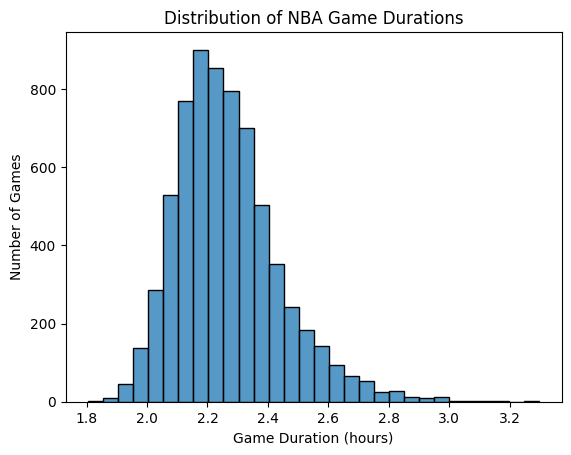

In [33]:
game_durations = pbp.groupby('GameID').Duration.first().reset_index() # Duration of each game
game_durations.Duration = game_durations.Duration / (60 * 60) # Changes duration from seconds to hours for ease
sns.histplot(game_durations.Duration, bins=30)

plt.xlabel('Game Duration (hours)')
plt.ylabel('Number of Games')
plt.title('Distribution of NBA Game Durations')

In [61]:
print(f"Number of Games: {pbp.GameID.nunique()}")

Number of Games: 6755


Text(0.5, 1.0, 'Fouls Committed vs Game Duration')

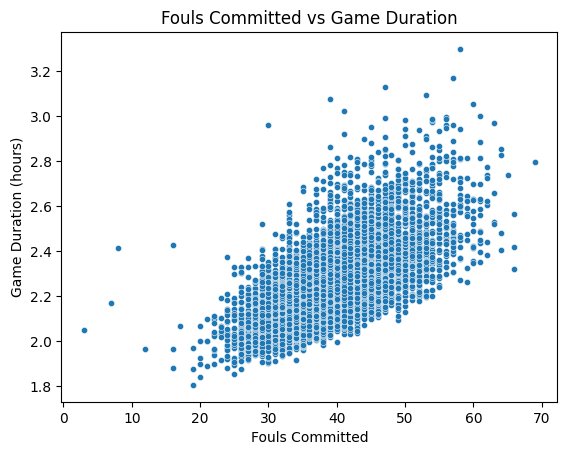

In [34]:
game_fouls = pbp[pbp.actionType == 'foul'].groupby('GameID').size().reset_index(name = 'Fouls') # Number of Fouls in every game
game_stats = pd.merge(game_durations, game_fouls, on = 'GameID')

sns.scatterplot(data = game_stats, x = 'Fouls', y = 'Duration', s = 20)
plt.xlabel('Fouls Committed')
plt.ylabel('Game Duration (hours)')
plt.title('Fouls Committed vs Game Duration')

Text(0.5, 1.0, 'Timeouts Used vs Game Duration')

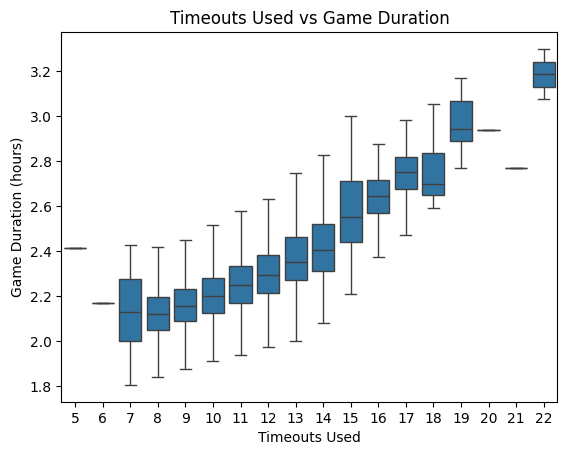

In [35]:
game_timeouts = pbp[pbp.actionType == 'timeout'].groupby('GameID').size().reset_index(name = 'Timeouts') # Number of Timeouts used
game_stats = pd.merge(game_stats, game_timeouts, on = 'GameID')

sns.boxplot(data = game_stats, x = 'Timeouts', y = 'Duration', showfliers = False)
plt.xlabel('Timeouts Used')
plt.ylabel('Game Duration (hours)')
plt.title('Timeouts Used vs Game Duration')

Text(0.5, 1.0, 'Final Score Differential vs Game Duration')

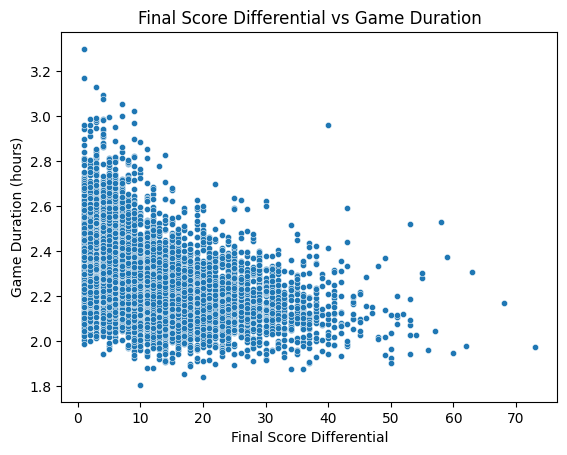

In [36]:
game_scorediff = pbp[pbp.actionType == 'game']
game_scorediff['ScoreDiff'] = abs(game_scorediff['scoreHome'] - game_scorediff['scoreAway'])
game_scorediff = game_scorediff[['GameID', 'ScoreDiff']] # Final Score Differential for each game

game_stats = pd.merge(game_stats, game_scorediff, on = 'GameID')

sns.scatterplot(data = game_stats, x = 'ScoreDiff', y = 'Duration', s = 20)
plt.xlabel('Final Score Differential')
plt.ylabel('Game Duration (hours)')
plt.title('Final Score Differential vs Game Duration')

In [37]:
def season_label(date):
    '''Assigns NBA season label based on date'''
    year, month = date.year, date.month
    if month >= 8: # August to December
        return f'{year} - {year + 1}'
    else:
        return f'{year - 1} - {year}'

pbp['Season'] = pbp.timeActual.apply(season_label)

Text(0.5, 1.0, 'Season vs Game Duration')

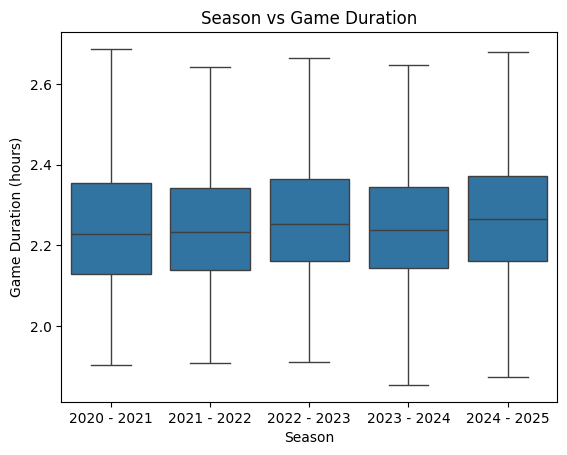

In [38]:
game_season = pbp.groupby('GameID').Season.first().reset_index() # Season of each game
game_stats = pd.merge(game_stats, game_season, on = 'GameID')

sns.boxplot(data = game_stats, x = 'Season', y = 'Duration', showfliers = False)
plt.xlabel('Season')
plt.ylabel('Game Duration (hours)')
plt.title('Season vs Game Duration')

In [39]:
pre_take_rule = game_stats[(game_stats.Season == '2020 - 2021') | (game_stats.Season == '2021 - 2022')] # Games before the '22 season rule change
post_take_rule = game_stats[(game_stats.Season == '2022 - 2023') | (game_stats.Season == '2023 - 2024') | (game_stats.Season == '2024 - 2025')]
stats.ttest_ind(pre_take_rule.Duration, post_take_rule.Duration, equal_var = True)

TtestResult(statistic=-4.299098563378501, pvalue=1.739057280686354e-05, df=6753.0)

In [40]:
pg.compute_effsize(pre_take_rule.Duration, post_take_rule.Duration, eftype='cohen')

-0.10757243808941791

In [62]:
pre_second_challenge = game_stats[(game_stats.Season == '2020 - 2021') | (game_stats.Season == '2021 - 2022') | (game_stats.Season == '2022 - 2023')] # Games before the '24 season rule change
post_second_challenge = game_stats[(game_stats.Season == '2023 - 2024') | (game_stats.Season == '2024 - 2025')]
stats.ttest_ind(pre_second_challenge.Duration, post_second_challenge.Duration, equal_var = True)

TtestResult(statistic=-2.030776431323203, pvalue=0.04231677810757093, df=6753.0)

In [63]:
pg.compute_effsize(pre_second_challenge.Duration, post_second_challenge.Duration, eftype='cohen')

-0.050193061450626054

In [41]:
game_ejections = pbp[pbp.actionType == 'ejection'].groupby('GameID').size().reset_index(name = 'Ejections') # Number of Ejections
game_stats = pd.merge(game_stats, game_ejections, on = 'GameID', how='left')

game_stoppages = pbp[pbp.actionType == 'stoppage'].groupby('GameID').size().reset_index(name = 'Stoppages') # Number of Stoppages
game_stats = pd.merge(game_stats, game_stoppages, on = 'GameID', how='left')

game_reviews = pbp[pbp.actionType == 'instantreplay'].groupby('GameID').size().reset_index(name = 'Reviews') # Number of Reviews
game_stats = pd.merge(game_stats, game_reviews, on = 'GameID', how='left')

game_crunch_timeouts = pbp[((pbp.actionType == 'timeout') & (pbp.period >= 4) & (pbp.clock < 5 * 60))]\
    .groupby('GameID').size().reset_index(name = 'CrunchTimeouts') # Number of Crunch Time Timeouts
game_stats = pd.merge(game_stats, game_crunch_timeouts, on = 'GameID', how='left')

game_substitutions = pbp[pbp.actionType == 'substitution'].groupby('GameID').size().reset_index(name = 'Substitutions') # Number of Substitutions
game_stats = pd.merge(game_stats, game_substitutions, on = 'GameID', how='left')

game_overtime = pbp.groupby('GameID').period.max().reset_index(name = 'MaxPeriod') # Number of Periods
game_overtime['Overtimes'] = game_overtime.MaxPeriod - 4 # Number of Overtime Periods
game_stats = pd.merge(game_stats, game_overtime[['GameID', 'Overtimes']], on = 'GameID', how='left')

In [42]:
game_stats.fillna(0, inplace=True) # Fill NaN values with 0 for games with no occurrences of certain events
game_stats.to_csv('nba_game_stats.csv', index=False) # Save game statistics to CSV file

Text(0.5, 1.0, 'Correlation Matrix of NBA Game Statistics')

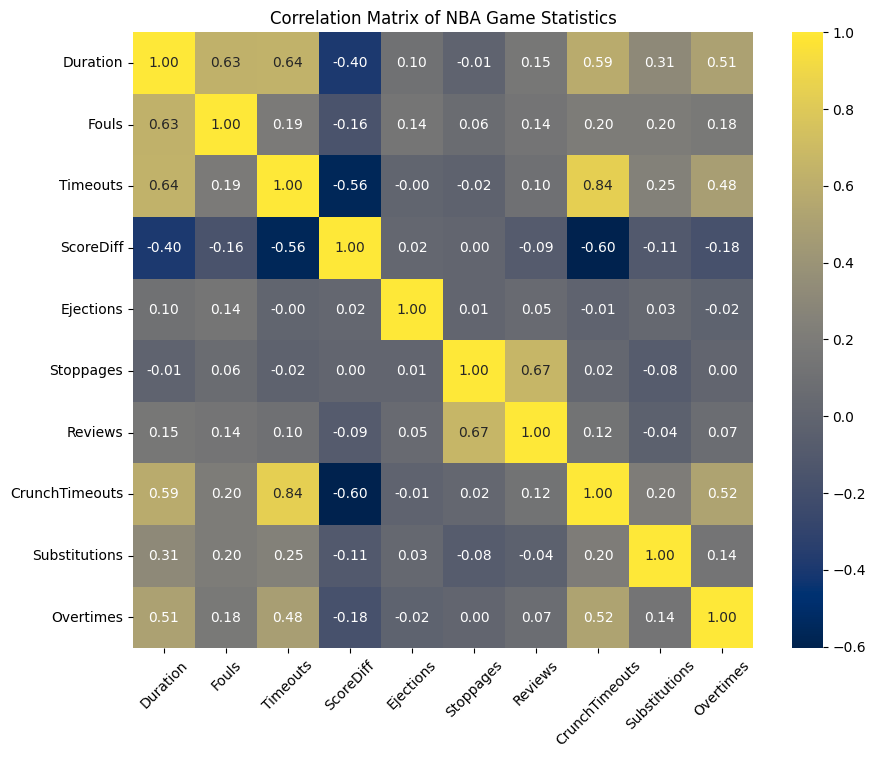

In [43]:
plt.figure(figsize=(10,8))
sns.heatmap(
    game_stats.drop(columns=['GameID', 'Season']).corr(),
    annot=True,
    fmt=".2f",
    cmap='cividis',
    cbar = True
)

plt.xticks(rotation = 45)
plt.title('Correlation Matrix of NBA Game Statistics')

## Model

In [44]:
df_games = game_stats.copy()

df_games = pd.get_dummies(df_games, columns=['Season'], drop_first=True) # One-hot encode the Season variable
df_games[['Season_2021 - 2022', 'Season_2022 - 2023', 'Season_2023 - 2024', 'Season_2024 - 2025']] \
    = df_games[['Season_2021 - 2022', 'Season_2022 - 2023', 'Season_2023 - 2024', 'Season_2024 - 2025']].astype(int) # Ensure dummy variables are integers
df_games['Duration'] = df_games.Duration * 60 # Convert Duration back to minutes for regression analysis

df_games.head()

,GameID,Duration,Fouls,Timeouts,ScoreDiff,Ejections,Stoppages,Reviews,CrunchTimeouts,Substitutions,Overtimes,Season_2021 - 2022,Season_2022 - 2023,Season_2023 - 2024,Season_2024 - 2025
0,12000001,138.350000,53,10,4,0.0,8.0,0.0,2.0,120,0.0,0,0,0,0
1,12000002,139.295000,46,11,6,0.0,17.0,1.0,2.0,108,0.0,0,0,0,0
2,12000003,129.655000,47,10,21,0.0,11.0,0.0,0.0,112,0.0,0,0,0,0
3,12000004,135.688333,42,9,6,0.0,7.0,2.0,1.0,96,0.0,0,0,0,0
4,12000005,136.713333,47,8,25,0.0,17.0,2.0,1.0,92,0.0,0,0,0,0


In [45]:
X = df_games.drop(columns=['GameID', 'Duration']) # All predictors
y = df_games['Duration'] # Response variable

X = sm.add_constant(X) # Add constant term for intercept
model_all = sm.OLS(y, X).fit()

print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1407.
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:46:20   Log-Likelihood:                -20913.
No. Observations:                6755   AIC:                         4.185e+04
Df Residuals:                    6741   BIC:                         4.195e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 76.6301      0

In [46]:
df_games['Overtimes'] = np.where(df_games['Overtimes'] == 0, 0, 1) # Convert Overtimes to binary variable

X = df_games.drop(columns=['GameID', 'Duration','CrunchTimeouts', 'Substitutions']) # All predictors (substitutions and crunch timeouts removed)
y = df_games['Duration'] # Response variable

X = sm.add_constant(X) # Add constant term for intercept
model_reduced = sm.OLS(y, X).fit()

print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:               Duration   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1604.
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:46:20   Log-Likelihood:                -21002.
No. Observations:                6755   AIC:                         4.203e+04
Df Residuals:                    6743   BIC:                         4.211e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 78.2673      0

## 4th Quarter Prediction

In [49]:
df_fourth = pbp[pbp.period == 4] # Filter to only 4th period events
df_fourth['ScoreDiff'] = abs(df_fourth['scoreHome'] - df_fourth['scoreAway']) # Calculate score differential for every play

df_fourth = df_fourth[(df_fourth.description != 'Game End') & (df_fourth.actionType != 'memo')]
game_end_times = df_fourth[df_fourth.description == 'Period End'][['GameID', 'timeActual']].reset_index() # Get end time of each game
game_end_times.rename(columns={'timeActual': 'GameEndTime'}, inplace=True)
df_fourth = pd.merge(df_fourth, game_end_times, on='GameID', how='left') # Merge end times into main dataframe
df_fourth['GameEndTime'] = pd.to_datetime(df_fourth['GameEndTime'], format = 'ISO8601') # Convert end times to datetime format
df_fourth['timeActual'] = pd.to_datetime(df_fourth['timeActual'], format = 'ISO8601') # Convert actual times to datetime format
df_fourth['TimeRemaining'] = (df_fourth['GameEndTime'] - df_fourth['timeActual']).dt.total_seconds() # Calculate time remaining in game for each play

df_fourth = df_fourth[df_fourth.TimeRemaining >= 0] # Removes small subset of plays with negative time remaining

df_fourth['isClutchTime'] = np.where((df_fourth['clock'] <= 5 * 60) & (df_fourth['ScoreDiff'] <= 5), 1, 0) # Identify clutch time plays
df_fourth['isCrunchTime'] = np.where((df_fourth['clock'] <= 2 * 60) & (df_fourth['ScoreDiff'] <= 5), 1, 0) # Identify crunch time plays

In [50]:
df_fourth['isFoul'] = np.where((df_fourth.actionType == 'foul') & (df_fourth.subType == 'personal'), 1, 0) # Indicator for team fouls

def fouls_up_to_time(df_game):
    ''' Calculates cumulative team fouls for every play in the quarter'''

    teams = df_game.teamId.dropna().unique() # Gets unique team IDs in the game
    
    df_game['fouls'] = df_game.groupby('teamId').isFoul.cumsum() # Cumulative fouls for each team

    df_game['team1_fouls'] =  np.where(df_game.teamId == teams[0], df_game['fouls'], np.nan) # Cumulative fouls for team 1
    df_game['team2_fouls'] = np.where(df_game.teamId == teams[1], df_game['fouls'], np.nan) # Cumulative fouls for team 2

    df_game['team1_fouls'] = df_game['team1_fouls'].ffill().fillna(0) # Forward fills for team 1 fouls
    df_game['team2_fouls'] = df_game['team2_fouls'].ffill().fillna(0) # Forward fills for team 2 fouls

    df_game.drop(columns = ['fouls'], inplace = True)
    
    return df_game

df_fourth = df_fourth.groupby('GameID').apply(fouls_up_to_time).reset_index(drop=True) # Apply fouls calculation to each game

df_fourth['team1_bonus'] = np.where(df_fourth['team1_fouls'] >= 5, 1, 0) # Team 1 in bonus indicator
df_fourth['team2_bonus'] = np.where(df_fourth['team2_fouls'] >= 5, 1, 0) # Team 2 in bonus indicator

C:\Users\danus\AppData\Local\Temp\ipykernel_42064\1617053711.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_fourth = df_fourth.groupby('GameID').apply(fouls_up_to_time).reset_index(drop=True) # Apply fouls calculation to each game


In [51]:
df_fourth['isTimeout'] = np.where(df_fourth.actionType == 'timeout', 1, 0) # Indicator for timeouts

df_fourth['Timeouts_Used'] = df_fourth.groupby('GameID').isTimeout.cumsum() # Cumulative timeouts used in the quarter

In [52]:
df_fourth = pd.get_dummies(df_fourth, columns = ['actionType'], drop_first= False, prefix= 'act') # One-hot encode action types

In [ ]:
from sklearn.model_selection import train_test_split

games = df_fourth['GameID'].unique() # List of all games

train_games, test_games = train_test_split(games, test_size=0.2, random_state=42) # Split games into training/test sets

df_train = df_fourth[df_fourth['GameID'].isin(train_games)]\
    [['ScoreDiff', 'clock', 'team1_fouls', 'team2_fouls', 'Timeouts_Used', 'TimeRemaining','isClutchTime', 'isCrunchTime', 'team1_bonus', 'team2_bonus']\
      + [col for col in df_fourth.columns if col.startswith('act_')]].drop_duplicates()

df_test = df_fourth[df_fourth['GameID'].isin(test_games)]\
    [['ScoreDiff', 'clock', 'team1_fouls', 'team2_fouls', 'Timeouts_Used', 'TimeRemaining', 'isClutchTime', 'isCrunchTime', 'team1_bonus', 'team2_bonus']\
      + [col for col in df_fourth.columns if col.startswith('act_')]].drop_duplicates()

X_train = df_train.drop(columns=['TimeRemaining'])
y_train = df_train['TimeRemaining']

X_test = df_test.drop(columns=['TimeRemaining'])
y_test = df_test['TimeRemaining']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

print(f"R^2: {model_linear.score(X_test, y_test)}")

y_pred = model_linear.predict(X_test)
mae = (np.mean(np.abs(y_test - y_pred)))

print(f"Mean absolute error: {mae}")

R^2: 0.8608955500202896
Mean absolute error: 178.77453954867937


In [172]:
from sklearn.ensemble import HistGradientBoostingRegressor

model_gb = HistGradientBoostingRegressor(max_iter = 1000, learning_rate = 0.05, max_depth = 3, random_state = 42, verbose = 1)
model_gb.fit(X_train, y_train)

print(f"R^2: {model_gb.score(X_test, y_test)}")

Binning 0.116 GB of training data: 0.194 s
Binning 0.013 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 1000 trees in 18.483 s, (7889 total leaves)
Time spent computing histograms: 10.103s
Time spent finding best splits:  0.171s
Time spent applying splits:      1.960s
Time spent predicting:           0.682s
R^2: 0.8712857711920807


In [173]:
y_pred = model_gb.predict(X_test)
mae = np.mean(np.abs(y_test - y_pred))

print(f"Mean absolute error: {mae}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")

Mean absolute error: 164.99015278528674
Root mean squared error: 226.1877432296515


In [132]:
df_evaluation = df_test.copy()
df_evaluation['Prediction'] = y_pred
df_evaluation['Error'] = abs(df_evaluation['TimeRemaining'] - df_evaluation['Prediction'])

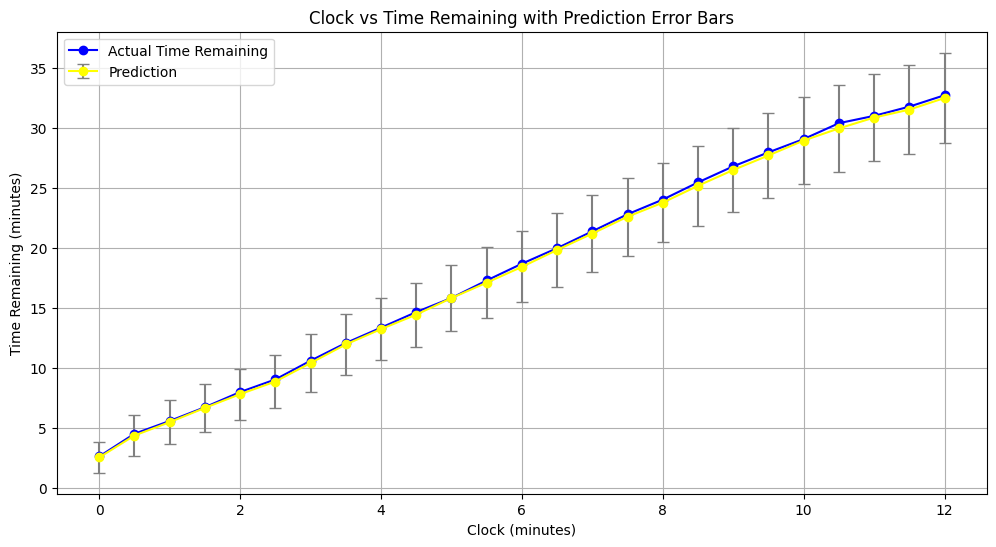

In [170]:
df_evaluation['Bin30'] = (df_evaluation['clock'] // 30) * 30 # Split into 30-second bins

by_30s = df_evaluation.groupby('Bin30')[['TimeRemaining', 'Prediction', 'Error']].mean().reset_index() # Average stats by bin

by_30s = by_30s/60

plt.figure(figsize=(12, 6))
plt.errorbar(by_30s.Bin30, by_30s.Prediction, yerr = by_30s.Error, fmt='o-', ecolor='grey', label='Prediction', capsize = 4, color = 'yellow')
plt.plot(by_30s.Bin30, by_30s.TimeRemaining, label='Actual Time Remaining', color='blue', marker='o')

plt.xlabel('Clock (minutes)')
plt.ylabel('Time Remaining (minutes)')
plt.title('Clock vs Time Remaining with Prediction Error Bars')
plt.legend()
plt.grid(True)
plt.show()
